In [3]:
import os
import numpy as np
import rasterio
from sklearn.linear_model import TheilSenRegressor
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

In [4]:
data_dir = 'data/'
lakes = ['Pichola', 'Chilika', 'Tungabhadra', 'Sukhna']
buffer_dists = [100, 500, 1000, 2000, 3000, 5000]

lake_coords = {
    'Pichola': (73.679, 24.572),
    'Chilika': (85.3, 19.5),
    'Tungabhadra': (76.333, 15.3),
    'Sukhna': (76.817, 30.733)
}

In [5]:
def load_multiband(path):
    print(f"Loading: {path}")
    with rasterio.open(path) as src:
        data = src.read()
        profile = src.profile
        transform = src.transform
        print(f"  Bands: {data.shape[0]}, Size: {data.shape[1]}x{data.shape[2]}")
        print(f"  CRS: {profile['crs']}")
    return data, profile, transform

In [6]:

# def compute_pixelwise_slope(ts_stack):
#     # Shape: (bands, rows, cols)
#     n_years = ts_stack.shape[0]
#     X = np.arange(n_years).reshape(-1, 1)
#     slope = np.full(ts_stack.shape[1:], np.nan)

#     for i in range(ts_stack.shape[1]):
#         for j in range(ts_stack.shape[2]):
#             y = ts_stack[:, i, j]
#             if np.isnan(y).all():
#                 continue
#             mask_nan = ~np.isnan(y)
#             if np.count_nonzero(mask_nan) < 5:
#                 continue
#             model = TheilSenRegressor()
#             model.fit(X[mask_nan], y[mask_nan])
#             slope[i, j] = model.coef_[0]
#     return slope

def ols_slope(stack):
    # stack shape: (time, rows, cols)
    t = np.arange(stack.shape[0])[:, None, None]
    mask = ~np.isnan(stack)
    
    # demean time & data
    t_mean = np.nanmean(np.where(mask, t, np.nan), axis=0, keepdims=True)
    y_mean = np.nanmean(stack, axis=0, keepdims=True)
    
    t_d = t - t_mean
    y_d = stack - y_mean
    
    num = np.nansum(t_d * y_d, axis=0)
    den = np.nansum(t_d ** 2, axis=0)
    slope = np.where(den == 0, np.nan, num / den)
    return slope


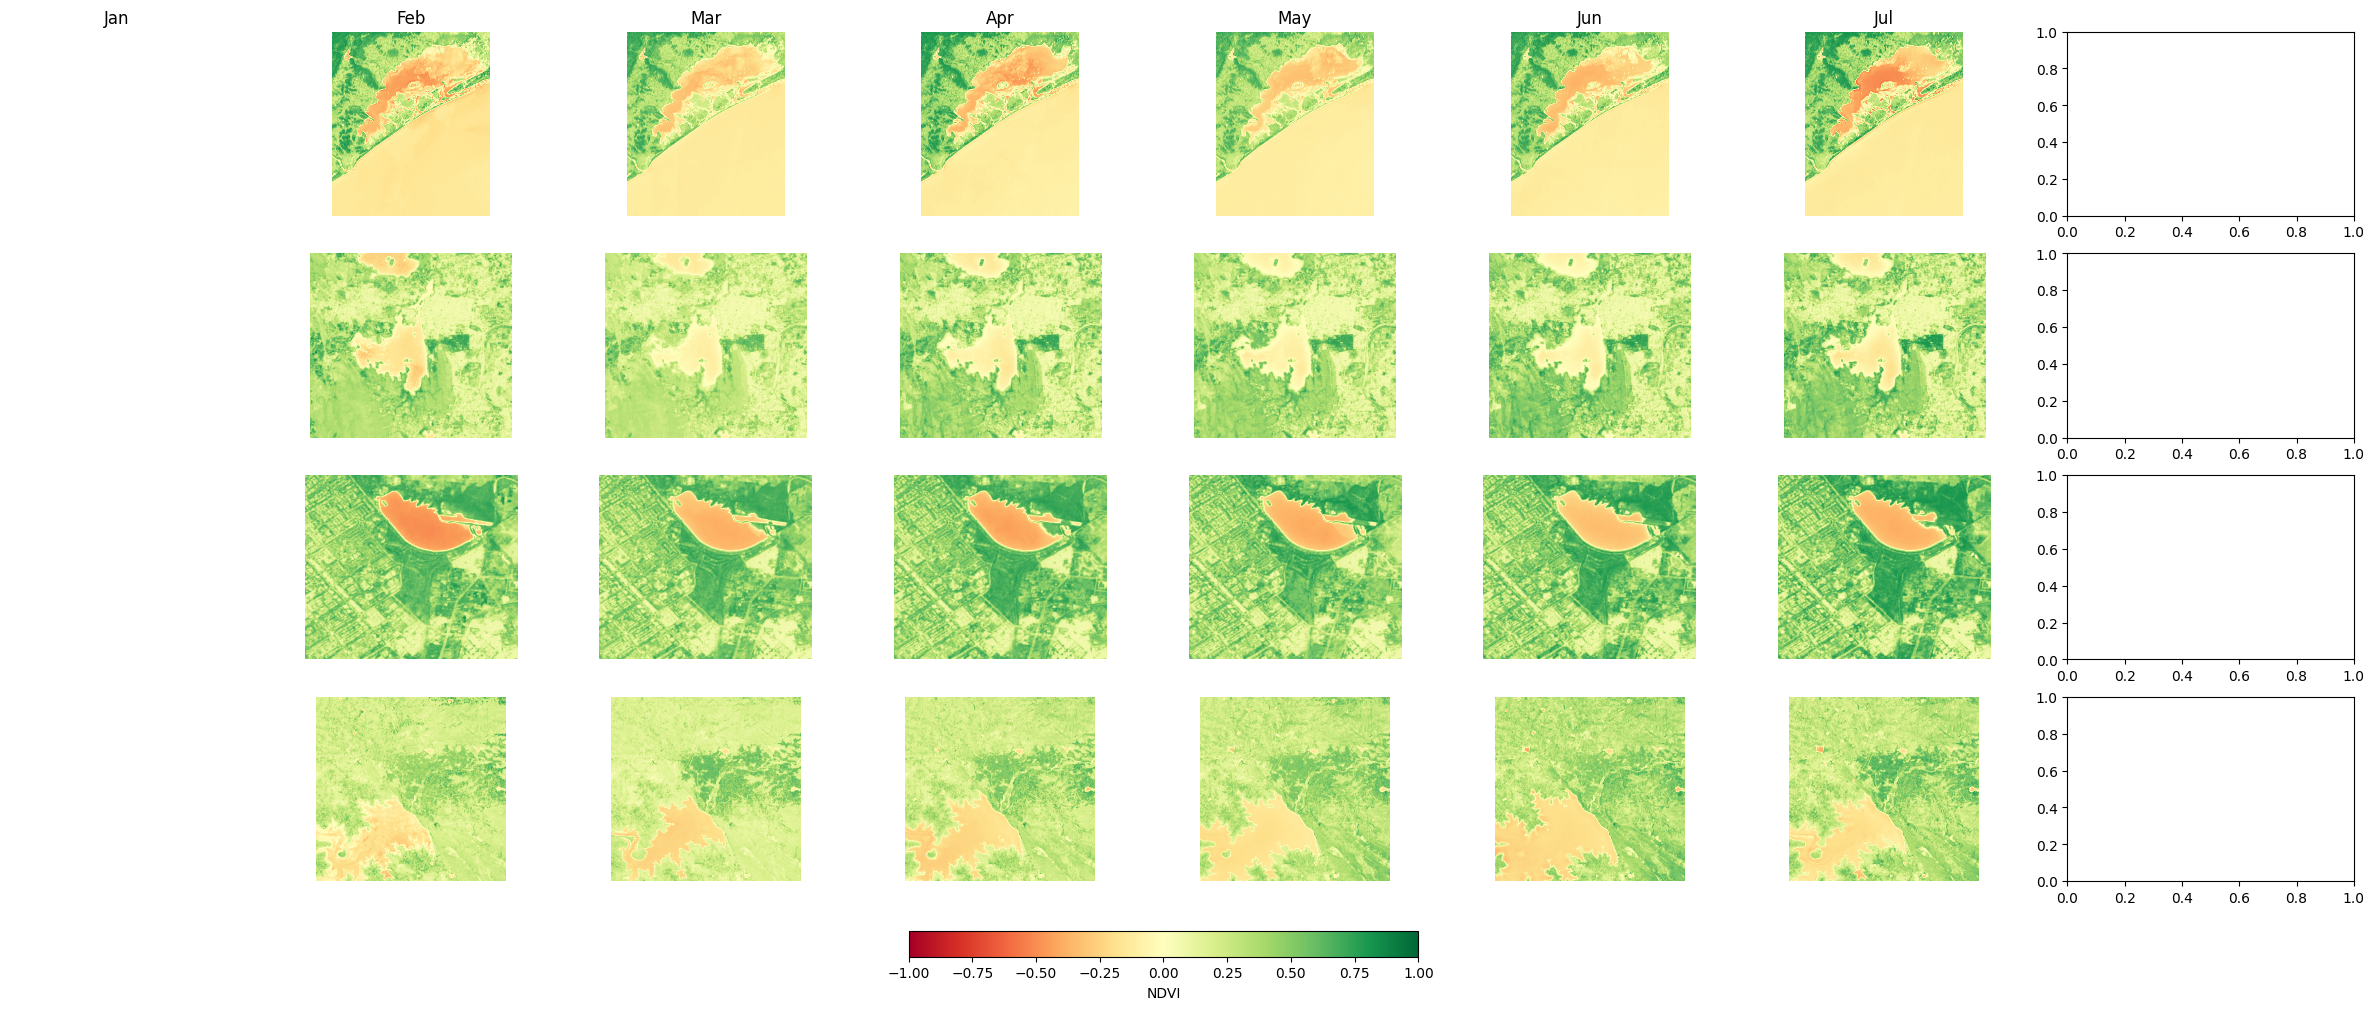

In [14]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# List of NDVI files for each lake
ndvi_files = {
    "Chilika": "data/NDVI_Chilika_Seasonal_2015_2024.tif",
    "Pichola": "data/NDVI_Pichola_Seasonal_2015_2024.tif",
    "Sukhna": "data/NDVI_Sukhna_Seasonal_2015_2024.tif",
    "Tungabhadra": "data/NDVI_Tungabhadra_Seasonal_2015_2024.tif"
}

# Band to month mapping (assuming bands 1–8 as Jan, Feb, Apr, Jul–Oct)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]

# Plot setup: 4 lakes × 8 bands
fig, axes = plt.subplots(len(ndvi_files), 8, figsize=(24, 10), constrained_layout=True)

# Standard NDVI scale
vmin, vmax = -1, 1

# Loop through lakes and plot each band
for row_idx, (lake_name, path) in enumerate(ndvi_files.items()):
    with rasterio.open(path) as src:
        for col_idx in range(7):
            ax = axes[row_idx, col_idx] if len(ndvi_files) > 1 else axes[col_idx]
            band = src.read(col_idx + 1)
            band = np.where(np.isnan(band), np.nan, band)

            im = ax.imshow(band, cmap='RdYlGn', vmin=vmin, vmax=vmax)
            ax.axis('off')

            if row_idx == 0:
                ax.set_title(month_labels[col_idx], fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(lake_name, fontsize=12, rotation=0, labelpad=40, va='center')

# Add a single shared colorbar
fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.03, pad=0.03, label="NDVI")

plt.show()


In [5]:
results = []

In [6]:
for lake in lakes:
    print(f"\n🟡 Processing lake: {lake}")
    
    ndvi_path = os.path.join(data_dir, f'NDVI_{lake}_Seasonal_2015_2024.tif')
    lst_path  = os.path.join(data_dir, f'L8_LST_{lake}_Summer_2013_2024.tif')

    ndvi_stack, ndvi_profile, transform = load_multiband(ndvi_path)
    lst_stack, _, _ = load_multiband(lst_path)

    # Split dry and monsoon
    ndvi_dry     = ndvi_stack[::2, :, :]
    ndvi_monsoon = ndvi_stack[1::2, :, :]

    # Compute slopes
    slope_dry     = ols_slope(ndvi_dry)
    slope_monsoon = ols_slope(ndvi_monsoon)
    slope_lst     = ols_slope(lst_stack)

    print("  Creating buffer zones")
    # (1) Make point in WGS‑84
    pt_wgs = gpd.GeoDataFrame(
        geometry=[Point(lake_coords[lake])], crs="EPSG:4326")

    # (2) Project to UTM metres (zone 44N) and build buffers
    pt_utm  = pt_wgs.to_crs(epsg=32644)
    buffers_geom = []          # this will store plain shapely Polygons
    for d in buffer_dists:
        ring_utm = pt_utm.geometry.iloc[0].buffer(d)   # shapely Polygon
        ring_wgs = gpd.GeoSeries([ring_utm], crs=pt_utm.crs) \
                    .to_crs(ndvi_profile['crs']) \
                    .iloc[0]                         # shapely in EPSG:4326
        buffers_geom.append(ring_wgs)

    # ---------------  Zonal stats with extra logging  ---------------
    for dist, geom in zip(buffer_dists, buffers_geom):
        print(f"  ▸ Buffer {dist} m intersects raster? ",
            rasterio.features.geometry_mask([geom],
                                            transform=transform,
                                            out_shape=slope_dry.shape,
                                            invert=True).any())

        try:
            zs_dry = zonal_stats([geom], slope_dry, affine=transform,
                                stats='mean', nodata=np.nan)[0]['mean']
            zs_mon = zonal_stats([geom], slope_monsoon, affine=transform,
                                stats='mean', nodata=np.nan)[0]['mean']
            zs_lst = zonal_stats([geom], slope_lst, affine=transform,
                                stats='mean', nodata=np.nan)[0]['mean']

            print(f"    NDVI dry slope:     {zs_dry}")
            print(f"    NDVI monsoon slope: {zs_mon}")
            print(f"    LST slope:          {zs_lst}")

            results.append({
                'lake': lake,
                'buffer_m': dist,
                'ndvi_dry_slope': zs_dry,
                'ndvi_monsoon_slope': zs_mon,
                'lst_slope': zs_lst
            })
        except Exception as e:
            print(f"    ❌ Zonal‑stats failed: {e}")
            results.append({
                'lake': lake,
                'buffer_m': dist,
                'ndvi_dry_slope': None,
                'ndvi_monsoon_slope': None,
                'lst_slope': None
            })
    # -------------------------------------------------------------------------------


🟡 Processing lake: Pichola
Loading: data/NDVI_Pichola_Seasonal_2015_2024.tif
  Bands: 8, Size: 602x657
  CRS: EPSG:4326
Loading: data/L8_LST_Pichola_Summer_2013_2024.tif
  Bands: 12, Size: 202x220
  CRS: EPSG:4326
  Creating buffer zones
  ▸ Buffer 100 m intersects raster?  True
    NDVI dry slope:     -0.00801207190905979
    NDVI monsoon slope: 0.01726548426637524
    LST slope:          None
  ▸ Buffer 500 m intersects raster?  True
    NDVI dry slope:     -0.00380746619007051
    NDVI monsoon slope: 0.01920354014790034
    LST slope:          None
  ▸ Buffer 1000 m intersects raster?  True
    NDVI dry slope:     0.0020202303574466695
    NDVI monsoon slope: 0.019687670786199228
    LST slope:          None
  ▸ Buffer 2000 m intersects raster?  True
    NDVI dry slope:     0.009607634528329545
    NDVI monsoon slope: 0.017196999802375913
    LST slope:          -0.3343262915287461
  ▸ Buffer 3000 m intersects raster?  True
    NDVI dry slope:     0.011735657755631476
    NDVI mons

In [7]:
df = pd.DataFrame(results)
print("Final Results Table:")
print(df)

df.to_csv('data/lake_buffer_slope_summary.csv', index=False)
print("Saved to ../data/lake_buffer_slope_summary.csv")

Final Results Table:
           lake  buffer_m  ndvi_dry_slope  ndvi_monsoon_slope  lst_slope
0       Pichola       100       -0.008012            0.017265        NaN
1       Pichola       500       -0.003807            0.019204        NaN
2       Pichola      1000        0.002020            0.019688        NaN
3       Pichola      2000        0.009608            0.017197  -0.334326
4       Pichola      3000        0.011736            0.014794  -0.575569
5       Pichola      5000        0.012011            0.014415  -0.716959
6       Chilika       100        0.001809            0.016370        NaN
7       Chilika       500        0.001194            0.017073        NaN
8       Chilika      1000        0.000930            0.017228        NaN
9       Chilika      2000        0.000698            0.016999        NaN
10      Chilika      3000        0.000681            0.016643        NaN
11      Chilika      5000        0.000288            0.018943        NaN
12  Tungabhadra       100     

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/lake_buffer_slope_summary.csv')

# Handy helpers
km = df['buffer_m'] / 1000.0
lakes = df['lake'].unique()

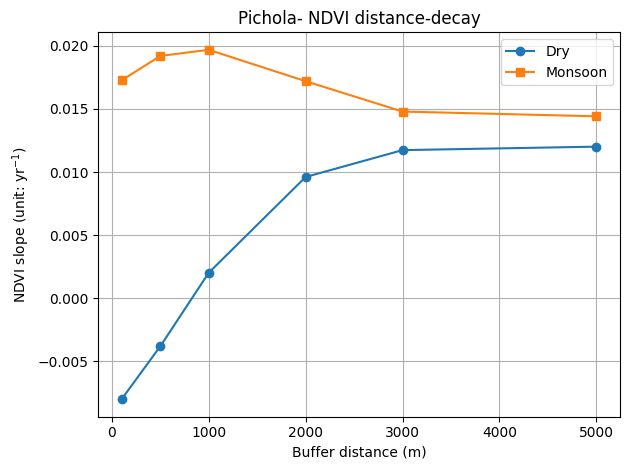

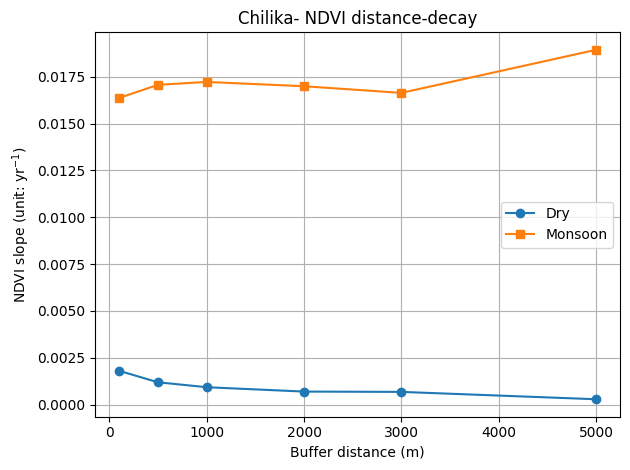

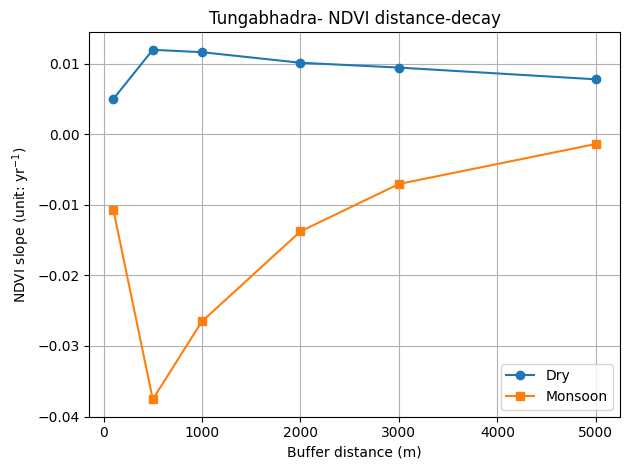

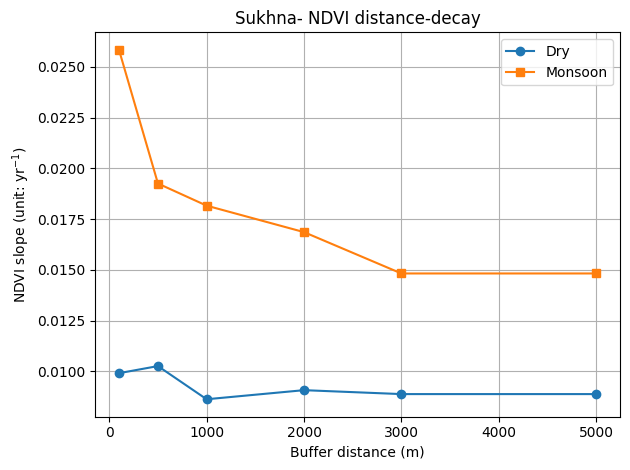

In [9]:
for lake in lakes:
    sub = df[df['lake'] == lake].sort_values('buffer_m')
    # --- Figure: NDVI distance‑decay ---
    plt.figure()
    plt.plot(sub['buffer_m'], sub['ndvi_dry_slope'],  marker='o', label='Dry')
    plt.plot(sub['buffer_m'], sub['ndvi_monsoon_slope'], marker='s', label='Monsoon')
    plt.xlabel('Buffer distance (m)')
    plt.ylabel('NDVI slope (unit: yr$^{-1}$)')
    plt.title(f'{lake}- NDVI distance-decay')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/{lake}_NDVI_distance_decay.png', dpi=300)
    plt.show()

    # # --- Figure: LST distance‑decay (skip if all NaN) ---
    # if sub['lst_slope'].notna().any():
    #     plt.figure()
    #     plt.plot(sub['buffer_m'], sub['lst_slope'], marker='^')
    #     plt.xlabel('Buffer distance (m)')
    #     plt.ylabel('LST slope (°C yr$^{-1}$)')
    #     plt.title(f'{lake}-LST distance-decay')
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.savefig(f'figures/{lake}_LST_distance_decay.png', dpi=300)
    #     plt.show()


How to interpret the graphs:

X-axis: Distance from lake in meters
Y-axis: NDVI trend slope (unit: change per year)

The slope of NDVI tells us how vegetation is changing over time

+ve slope → Greening trend (vegetation is increasing).
–ve slope → Browning trend (vegetation is declining).

By comparing across distances, we understand:
    Does the vegetation near the lake improve faster than further away?
    Does this behavior differ between seasons?

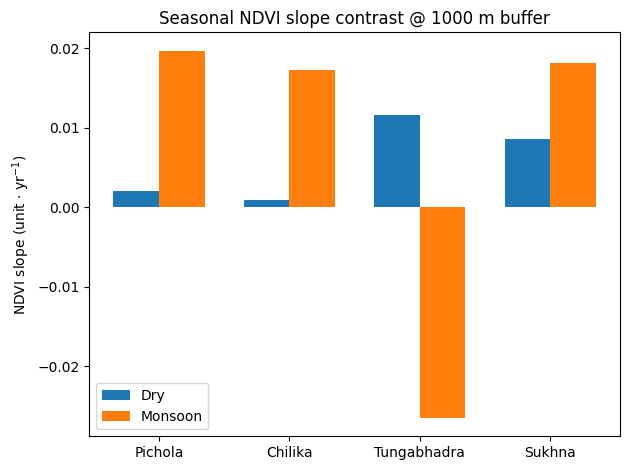

In [10]:
plt.figure()
buffer_target = 1000
bars = []

for lake in lakes:
    row = df[(df['lake'] == lake) & (df['buffer_m'] == buffer_target)]
    bars.append((row['ndvi_dry_slope'].values[0], row['ndvi_monsoon_slope'].values[0]))

x = range(len(lakes))
dry_vals, mon_vals = zip(*bars)

bar_width = 0.35
plt.bar(x, dry_vals,  width=bar_width, label='Dry')
plt.bar([p + bar_width for p in x], mon_vals, width=bar_width, label='Monsoon')

plt.xticks([p + bar_width/2 for p in x], lakes)
plt.ylabel('NDVI slope (unit · yr$^{-1}$)')
plt.title(f'Seasonal NDVI slope contrast @ {buffer_target} m buffer')
plt.legend()
plt.tight_layout()
plt.savefig('figures/seasonal_contrast_bar.png', dpi=300)
plt.show()


How to Interpret:
Bar chart of NDVI trend at 1 km buffer.

Bars for each lake, split by:
    Blue = Dry season,
    Orange = Monsoon season.

This chart highlights seasonal differences:
    Is the greening happening only in the monsoon?
    Is one season deteriorating while the other improves?

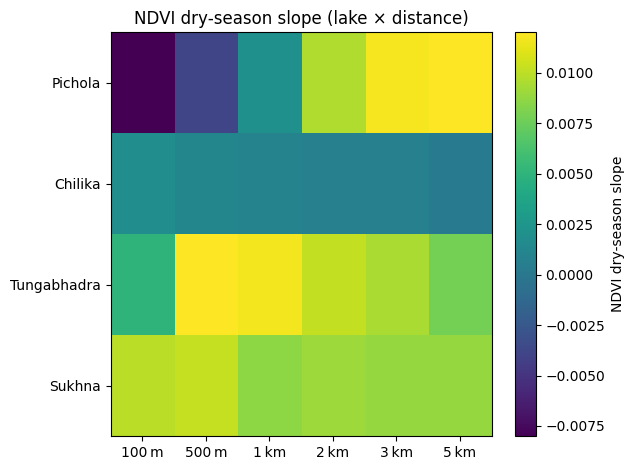

In [11]:
import numpy as np
plt.figure()

# Pivot table: lakes × buffer_dists
heat = (df.pivot(index='lake',
                 columns='buffer_m',
                 values='ndvi_dry_slope')
          .reindex(lakes))      # preserve original order

im = plt.imshow(heat.values, aspect='auto', interpolation='nearest')
plt.colorbar(im, label='NDVI dry‑season slope')

plt.xticks(ticks=np.arange(len(buffer_dists)),
           labels=[f'{b//1000} km' if b>=1000 else f'{b} m' for b in buffer_dists])
plt.yticks(ticks=np.arange(len(lakes)), labels=lakes)
plt.title('NDVI dry‑season slope (lake × distance)')
plt.tight_layout()
plt.savefig('figures/ndvi_dry_heatmap.png', dpi=300)
plt.show()


How to Interpret:

Each cell is a combination of:
    A lake (rows),
    A buffer distance (columns),
    And the dry season NDVI slope.

Colorbar tells us what values mean:
    Yellow/green = Positive slope (greening),
    Purple = Negative slope (browning).

This helps compare all lakes and distances at once.

Look for:
    Bright green → Good improvement in vegetation.
    Purple → Declining vegetation.
    You can visually trace patterns like:
    Does one lake consistently have lower NDVI?
    Is 100 m always better than 5 km?

In [ ]:
from scipy.stats import pearsonr
csv_path = 'lake_buffer_slope_summary.csv'   # adjust if needed
df = pd.read_csv(csv_path)

# 2.  Drop rows with missing LST slope (NaNs)
df_valid = df.dropna(subset=['lst_slope']).copy()

# 3.  Loop through lakes and create scatter plots
for lake in df_valid['lake'].unique():
    sub = df_valid[df_valid['lake'] == lake]

    # Keep only rows where both NDVI & LST slope exist
    sub_dry  = sub.dropna(subset=['ndvi_dry_slope', 'lst_slope'])
    sub_mon  = sub.dropna(subset=['ndvi_monsoon_slope', 'lst_slope'])

    # ---- Dry-season scatter ----
    if len(sub_dry) >= 2:
        plt.figure()
        plt.scatter(sub_dry['ndvi_dry_slope'], sub_dry['lst_slope'])
        for _, row in sub_dry.iterrows():
            plt.text(row['ndvi_dry_slope'], row['lst_slope'], f"{row['buffer_m']} m")
        plt.xlabel('NDVI dry-season slope')
        plt.ylabel('LST slope (°C · yr⁻¹)')
        plt.title(f'{lake}: NDVI (dry) vs LST slope')
        plt.grid(True); plt.tight_layout()
        plt.savefig(f'figures/{lake}_dry_vs_lst.png', dpi=300)
        plt.show()

        r, p = pearsonr(sub_dry['ndvi_dry_slope'], sub_dry['lst_slope'])
        print(f'{lake}  Dry-season correlation  r={r:.3f},  p={p:.3f}')
    else:
        print(f'{lake}: not enough dry-season points for correlation.')

    # ---- Monsoon scatter ----
    if len(sub_mon) >= 2:
        plt.figure()
        plt.scatter(sub_mon['ndvi_monsoon_slope'], sub_mon['lst_slope'])
        for _, row in sub_mon.iterrows():
            plt.text(row['ndvi_monsoon_slope'], row['lst_slope'], f"{row['buffer_m']} m")
        plt.xlabel('NDVI monsoon slope')
        plt.ylabel('LST slope (°C · yr⁻¹)')
        plt.title(f'{lake}: NDVI (monsoon) vs LST slope')
        plt.grid(True); plt.tight_layout()
        plt.savefig(f'figures/{lake}_monsoon_vs_lst.png', dpi=300)
        plt.show()

        r, p = pearsonr(sub_mon['ndvi_monsoon_slope'], sub_mon['lst_slope'])
        print(f'{lake}  Monsoon correlation  r={r:.3f},  p={p:.3f}')
    else:
        print(f'{lake}: not enough monsoon points for correlation.')


       lake  buffer_m  ndvi_dry_slope  ndvi_monsoon_slope  lst_slope
3   Pichola      5000        0.012011            0.014415  -0.166388
15   Sukhna      5000        0.008878            0.014821  -0.020099
Pichola: not enough dry-season points for correlation.
Pichola: not enough monsoon points for correlation.
Sukhna: not enough dry-season points for correlation.
Sukhna: not enough monsoon points for correlation.
